
## Installs

Step 1: created conda env and installed rdkit (this installs the correct version of python)

* conda create -c conda-forge -n my-rdkit-env rdkit

Step 2:

* installed all other dependencies via pip



## Train a variational autoencoder to generate molecules.  

* the models use tensorflow

* needs GPU

In [2]:

import deepchem as dc
from deepchem.models.optimizers import ExponentialDecay
from deepchem.models.seqtoseq import AspuruGuzikAutoEncoder

import numpy as np
from rdkit import Chem
from random import shuffle

from rdkit.Chem import QED

from rdkit.Chem.Draw import IPythonConsole


In [3]:

batch_size = 100


In [4]:


tasks, datasets, transformers = dc.molnet.load_muv()
train_dataset, valid_dataset, test_dataset = datasets

train_smiles = train_dataset.ids     ## takes too long




In [5]:

print( len(train_dataset.ids)  )
print( len(train_smiles)  )


74469
74469


In [6]:

'''

train_smiles = train_dataset.ids
shuffle(train_smiles)
train_smiles = train_smiles[:16000]

print( len(train_smiles)  )

'''


'\n\ntrain_smiles = train_dataset.ids\nshuffle(train_smiles)\ntrain_smiles = train_smiles[:16000]\n\nprint( len(train_smiles)  )\n\n'

In [7]:


print( train_smiles  )



['NC(=O)NC(Cc1ccccc1)C(=O)O' 'Nc1ccc(C(=O)O)c(O)c1'
 'C=CCNC(=S)Nc1ccc(Br)cc1F' ...
 'CC(=O)Nc1ccc(NC(=O)Cc2ccc(S(=O)(=O)N3CCCCC3)s2)cc1'
 'COc1ccc(N(C(=O)c2cccnc2)S(=O)(=O)c2cccs2)cc1'
 'COc1ccc(S(=O)(=O)N2CCCN(CCC(=O)Nc3cccc(C(F)(F)F)c3)CC2)cc1']


## Visualize a molecule

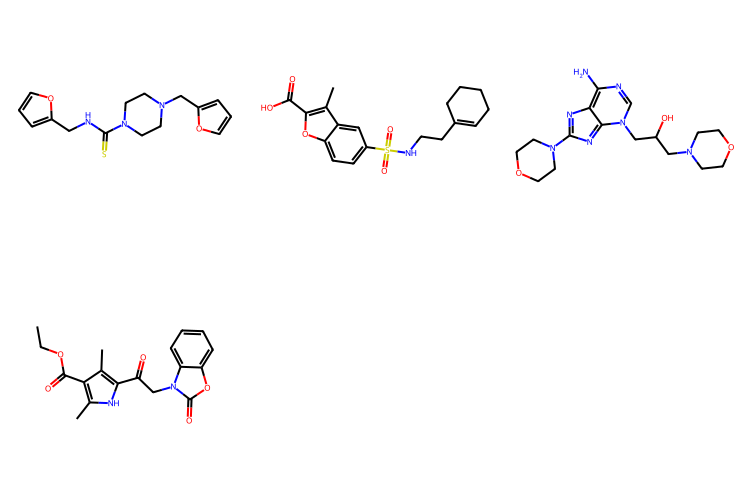

In [8]:

molecule_samples = ['S=C(NCc1ccco1)N1CCN(Cc2ccco2)CC1','Cc1c(C(=O)O)oc2ccc(S(=O)(=O)NCCC3=CCCCC3)cc12',
         'Nc1ncn(CC(O)CN2CCOCC2)c2nc(N3CCOCC3)nc1-2','CCOC(=O)c1c(C)[nH]c(C(=O)Cn2c(=O)oc3ccccc32)c1C' ]

molecule_samples_mol = [ Chem.MolFromSmiles(x) for x in molecule_samples]


Chem.Draw.MolsToGridImage(
          molecule_samples_mol,
          molsPerRow=3,
          subImgSize=(250, 250)
)



* Find the set of tokens that can appear
* and the maximum length of the SMILES strings we are working with.


In [9]:

tokens = set()

for s in train_smiles:
  tokens = tokens.union(set(s))

tokens = sorted(list(tokens))

max_length = max(len(s) for s in train_smiles)



## Build the model


In [10]:


batches_per_epoch = len(train_smiles)/batch_size

learning_rate     = ExponentialDecay(0.001, 0.95, batches_per_epoch)

model = AspuruGuzikAutoEncoder(
             tokens, 
             max_length, 
             model_dir='vae', 
             batch_size=batch_size, 
             learning_rate=learning_rate
)




## Train the model


In [11]:


def generate_sequences(epochs):
  for i in range(epochs):
    print(i)
    for s in train_smiles:
      yield (s, s)

    

In [12]:

epochs = 10   ## 50

model.fit_sequences(generate_sequences(epochs))


0
1
2
3
4
5
6
7
8
9




## Generate some new molecules


In [13]:

predictions = model.predict_from_embeddings(np.random.normal(size=(1000,196)))


In [14]:

molecules = []

for p in predictions:
  smiles = ''.join(p)
  if Chem.MolFromSmiles(smiles) is not None:
    molecules.append(smiles)


[00:39:51] SMILES Parse Error: syntax error while parsing: Cc1cccc(CCC=)CCCCCC))CCCCCC1
[00:39:51] SMILES Parse Error: Failed parsing SMILES 'Cc1cccc(CCC=)CCCCCC))CCCCCC1' for input: 'Cc1cccc(CCC=)CCCCCC))CCCCCC1'
[00:39:51] SMILES Parse Error: extra close parentheses while parsing: Cc1ccccccCCCCOCCCCCCCC)CC1
[00:39:51] SMILES Parse Error: Failed parsing SMILES 'Cc1ccccccCCCCOCCCCCCCC)CC1' for input: 'Cc1ccccccCCCCOCCCCCCCC)CC1'
[00:39:51] SMILES Parse Error: duplicated ring closure 1 bonds atom 1 to itself for input: 'Cc11cccccccccc11CCCCCCCC11'
[00:39:51] SMILES Parse Error: unclosed ring for input: 'Cc1cccc(C)ccccccc1CCCCCCCCC1'
[00:39:51] SMILES Parse Error: extra close parentheses while parsing: Cc1ccc(C)ccccccc1CCCCCCC)C1
[00:39:51] SMILES Parse Error: Failed parsing SMILES 'Cc1ccc(C)ccccccc1CCCCCCC)C1' for input: 'Cc1ccc(C)ccccccc1CCCCCCC)C1'
[00:39:51] SMILES Parse Error: duplicated ring closure 1 bonds atom 1 to itself for input: 'Cc11cccccccccccccC1'
[00:39:51] SMILES Parse E

In [15]:

print()
print('Generated molecules:')
for m in molecules:
  print(m)



Generated molecules:
Cc1ccc(CCC=O)CCCCCCCCC1
Cc1cccccccc11CCCCCCCCCC1
Cc1cccccccccc11CCCCCC1
Cc1cccccccc11CCCCCCCCC1
Cc1cccc(CCCO)cccccC1
Cc1cccccccc11CCCCCCCCC1
Cc1ccccc(CC=O)CCCCCCCCCCC1
Cc1ccc(CCCCC)CCCCCCCCCCCC1
C=1cCCCCCCCCCCCCCC1
Cc1ccc(C(=O)CCCCCCCCCCCCCC)C1
Cc1ccc(CC(=O)CCCCC)CCC1
C=1(CCCC=O)CCCCCCCCCCCC1
C=1cCCCCCCCCCCCCCCC1
Cc1cccCCCCCCCCCCCCCCC1
Cc1ccc(CC=O)CCCCCCCCCCCCC1
O=C1ccccccccc11CCCC1
C=1cc(CCCC=O)CCCCCCCC1
Cc1ccc(CCCCCCC)C1
Cc1ccc(CCCCC)CCCCCCC1
C=1cc(CCCCOO)CCCCCCCCCCC1
C=1cc(CCCCC)CCCCCCCCC1
Cc1ccc(C)ccccc11CCCCCCCCC1
Cc1cc(CC=O)CCCCCCCCCccccc1
Cc1cccccccccc11CCCCC1
Cc1ccc(C(=O)CCCCCCCCCCC)cc1
C=1cc(CCCCCO)CCCcccc1
Cc1cccc(CCC=O)cccccCCC1
C=1cc(C)ccccccccCCCC1
C=C(CCCCCCCCCC)CCCCCCC
Cc1cccccccc11CCCCCCCC1
Cc1cc(CCCC)cccccc(CCCCCC)ccccc1


In [16]:

print( molecules )


['Cc1ccc(CCC=O)CCCCCCCCC1', 'Cc1cccccccc11CCCCCCCCCC1', 'Cc1cccccccccc11CCCCCC1', 'Cc1cccccccc11CCCCCCCCC1', 'Cc1cccc(CCCO)cccccC1', 'Cc1cccccccc11CCCCCCCCC1', 'Cc1ccccc(CC=O)CCCCCCCCCCC1', 'Cc1ccc(CCCCC)CCCCCCCCCCCC1', 'C=1cCCCCCCCCCCCCCC1', 'Cc1ccc(C(=O)CCCCCCCCCCCCCC)C1', 'Cc1ccc(CC(=O)CCCCC)CCC1', 'C=1(CCCC=O)CCCCCCCCCCCC1', 'C=1cCCCCCCCCCCCCCCC1', 'Cc1cccCCCCCCCCCCCCCCC1', 'Cc1ccc(CC=O)CCCCCCCCCCCCC1', 'O=C1ccccccccc11CCCC1', 'C=1cc(CCCC=O)CCCCCCCC1', 'Cc1ccc(CCCCCCC)C1', 'Cc1ccc(CCCCC)CCCCCCC1', 'C=1cc(CCCCOO)CCCCCCCCCCC1', 'C=1cc(CCCCC)CCCCCCCCC1', 'Cc1ccc(C)ccccc11CCCCCCCCC1', 'Cc1cc(CC=O)CCCCCCCCCccccc1', 'Cc1cccccccccc11CCCCC1', 'Cc1ccc(C(=O)CCCCCCCCCCC)cc1', 'C=1cc(CCCCCO)CCCcccc1', 'Cc1cccc(CCC=O)cccccCCC1', 'C=1cc(C)ccccccccCCCC1', 'C=C(CCCCCCCCCC)CCCCCCC', 'Cc1cccccccc11CCCCCCCC1', 'Cc1cc(CCCC)cccccc(CCCCCC)ccccc1']


In [17]:

molecules_analysis = [ Chem.MolFromSmiles(x) for x in molecules]


In [18]:

print( molecules_analysis )   


[<rdkit.Chem.rdchem.Mol object at 0x0000029415B75620>, <rdkit.Chem.rdchem.Mol object at 0x0000029415B75770>, <rdkit.Chem.rdchem.Mol object at 0x0000029415B750E0>, <rdkit.Chem.rdchem.Mol object at 0x0000029415B75850>, <rdkit.Chem.rdchem.Mol object at 0x0000029415B75C40>, <rdkit.Chem.rdchem.Mol object at 0x0000029415B75CB0>, <rdkit.Chem.rdchem.Mol object at 0x0000029415B75D20>, <rdkit.Chem.rdchem.Mol object at 0x0000029415B75D90>, <rdkit.Chem.rdchem.Mol object at 0x0000029415B75E70>, <rdkit.Chem.rdchem.Mol object at 0x0000029415B75E00>, <rdkit.Chem.rdchem.Mol object at 0x0000029415B75EE0>, <rdkit.Chem.rdchem.Mol object at 0x0000029415B75F50>, <rdkit.Chem.rdchem.Mol object at 0x0000029415B75FC0>, <rdkit.Chem.rdchem.Mol object at 0x0000029415B76030>, <rdkit.Chem.rdchem.Mol object at 0x0000029415B760A0>, <rdkit.Chem.rdchem.Mol object at 0x0000029415B76110>, <rdkit.Chem.rdchem.Mol object at 0x0000029415B76180>, <rdkit.Chem.rdchem.Mol object at 0x0000029415B761F0>, <rdkit.Chem.rdchem.Mol obje

## Visualize

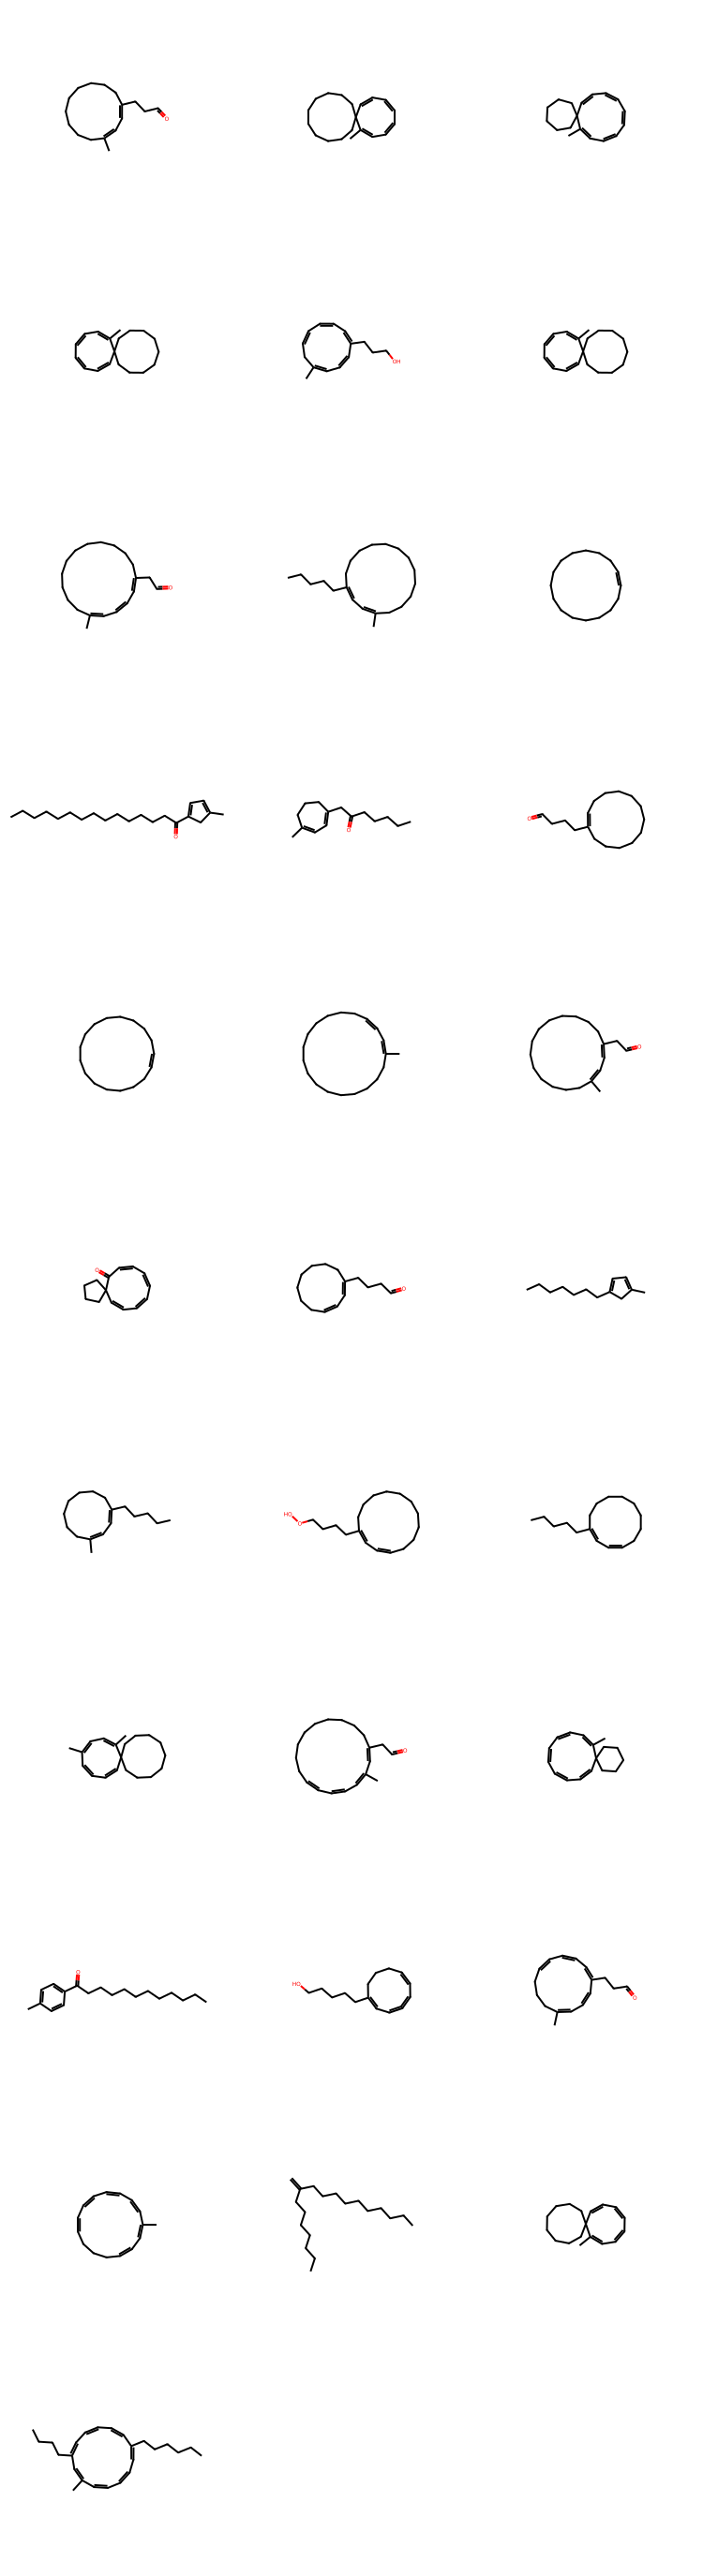

In [19]:

Chem.Draw.MolsToGridImage(
          molecules_analysis,
          molsPerRow=3,
          subImgSize=(250, 250)
)


## Analyze and Select molecules

In [20]:

print(    sorted(  [x.GetNumAtoms() for x in molecules_analysis]   )    )


[13, 15, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 18, 18, 18, 18, 18, 19, 19, 19, 20, 20, 20, 20, 20, 21, 21, 21, 22, 22, 25]


In [21]:

good_mol_list = [x for x in molecules_analysis if x.GetNumAtoms() > 10 and x.GetNumAtoms() < 50 ]
print(   len(good_mol_list)   )


31



## Quantitative Estimate of drug likeness (QED score)


In [22]:

qed_list = [  Chem.QED.qed(x) for x in good_mol_list ]

final_mol_list = [ (a, b) for a, b in zip(good_mol_list, qed_list) if b > 0.2 ]


In [23]:

final_mol_list


[(<rdkit.Chem.rdchem.Mol at 0x29415b75620>, 0.6141636659130715),
 (<rdkit.Chem.rdchem.Mol at 0x29415b75770>, 0.470034281792302),
 (<rdkit.Chem.rdchem.Mol at 0x29415b750e0>, 0.5233260338734754),
 (<rdkit.Chem.rdchem.Mol at 0x29415b75850>, 0.48909703980982683),
 (<rdkit.Chem.rdchem.Mol at 0x29415b75c40>, 0.7622516922154836),
 (<rdkit.Chem.rdchem.Mol at 0x29415b75cb0>, 0.48909703980982683),
 (<rdkit.Chem.rdchem.Mol at 0x29415b75d20>, 0.5441165300495387),
 (<rdkit.Chem.rdchem.Mol at 0x29415b75d90>, 0.4596876503562698),
 (<rdkit.Chem.rdchem.Mol at 0x29415b75e70>, 0.4397162799631667),
 (<rdkit.Chem.rdchem.Mol at 0x29415b75e00>, 0.318124313705032),
 (<rdkit.Chem.rdchem.Mol at 0x29415b75ee0>, 0.5986048954017296),
 (<rdkit.Chem.rdchem.Mol at 0x29415b75f50>, 0.3610895969369216),
 (<rdkit.Chem.rdchem.Mol at 0x29415b75fc0>, 0.42635906423069325),
 (<rdkit.Chem.rdchem.Mol at 0x29415b76030>, 0.4334708912441309),
 (<rdkit.Chem.rdchem.Mol at 0x29415b760a0>, 0.5280626974192225),
 (<rdkit.Chem.rdchem.Mol


## Visualize


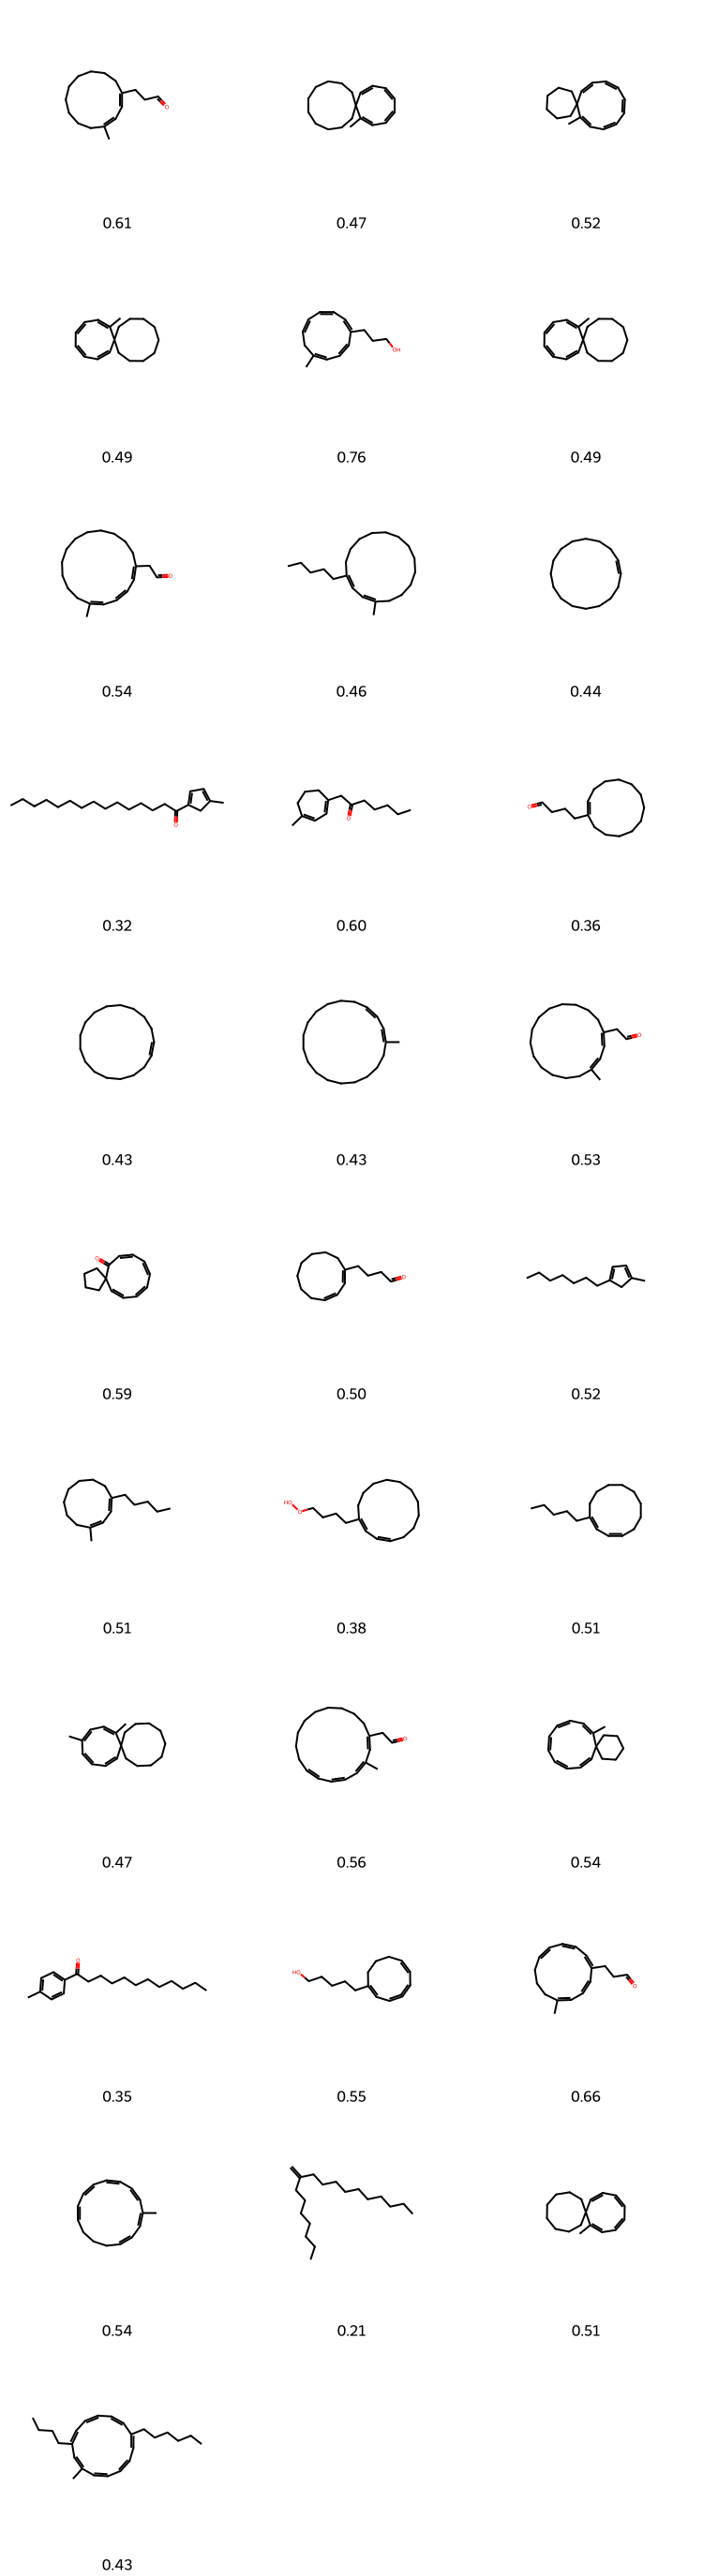

In [24]:

Chem.Draw.MolsToGridImage(
            [ x[0] for x in final_mol_list],
            molsPerRow=3,
            subImgSize=(250, 250),
            legends=[f"{x[1]:.2f}" for x in final_mol_list]
                          
)
